In [16]:
import numpy as np
import scipy as sp
from matplotlib.pyplot import cm
# my libraries import 
import preprocessing as prep
import plot as plt
import mvg
import utility as util
import logistic_regression as lr
import dcf 
import gmm 
import svm
import pickle

from copy import deepcopy

In [17]:
N_FEATURES = 12
# preprocessing 
dim_reduction = None
m = 9
dim_reduction_ = dim_reduction if dim_reduction else ''
dim_reduction_ = dim_reduction_ if dim_reduction != 'PCA' else f"{dim_reduction_}-{m}-"

preprocessing = 'z-norm'
preprocessing_ = preprocessing if preprocessing else 'raw'


# enable models 
DATA_VISUALIZATION = False
MVG = False
LOGISTIC_REGRESSION = False
SVM = True
GMM = False
DIM_REDUCTION = True
FUSION = True

# dataset path
fileTR = './data/Train.txt'
fileTE = './data/Test.txt'

# named features 
features = ["Feature(" + str(x) + ")" for x in range(N_FEATURES)]

# load dataset
DTR, LTR = prep.load_dataset(fileTR)
DTE, LTE = prep.load_dataset(fileTE)



In [18]:
# folds preparation
applications = [(0.5, 1, 1), (0.1, 1, 1), (0.9, 1, 1)]
# n - folds
k = 4
# split DTR 
folds, folds_labels = prep.make_folds(DTR, LTR, k)

fold: 0  -  (12, 1500)
fold: 1  -  (12, 1500)
fold: 2  -  (12, 1500)
fold: 3  -  (12, 1500)


### Data Visualization  

In [4]:
if DATA_VISUALIZATION:
    if preprocessing == 'gau':
        DTR, _ = prep.preprocess_gaussianization(DTR, DTE)
    maleDTR = DTR[:, LTR == 0]
    femaleDTR = DTR[:, LTR == 1]
    plt.plot_features_distr(DTR, LTR, features)
    #plt.plot_relation_beetween_feautures(DTR, LTR, features)
    #plt.plot_heatmap(DTR, features, cm.Greys)
    #plt.plot_heatmap(maleDTR, features, cm.Blues)
    #plt.plot_heatmap(femaleDTR, features, cm.Reds)

### MVG

In [5]:
save_results = True
full = True
diag_full = True
tied_full = True
tied_diag = True

llrs_dict = dict()
if MVG:
    if full:
        print(f"----- MVG full covariance [{dim_reduction_} {preprocessing_}-features]-----")
        full_minDCFs = []
        for application in applications:
            pi, Cfn, Cfp = application
            print("Application with (pi:", pi,", Cfn",Cfn,", Cfp",Cfp,")")
            classPriors = [pi, 1-pi]
            llrs = util.k_folds(folds, folds_labels, k, mvg.MVG, dim_reduction=dim_reduction, m=m, classPriors=classPriors, preprocessing=preprocessing)
            llrs_full = np.hstack(llrs)
            minDCF = dcf.compute_min_DCF(llrs_full, np.hstack(folds_labels), pi, Cfn, Cfp)
            llrs_dict[application] = llrs_full
            print(f"\t\tMinDCF: {minDCF}")
            full_minDCFs.append(minDCF)
        if save_results:
            util.pickle_dump(f"./results/mvg/{dim_reduction_}{preprocessing_}-llrs_full_cov", llrs_dict)
    if diag_full:
        print(f"----- MVG diagonal covariance [{dim_reduction_} {preprocessing_}-features]-----")
        diag_minDCFs = []
        for application in applications:
            pi, Cfn, Cfp = application
            print("Application with (pi:", pi,", Cfn",Cfn,", Cfp",Cfp,")")
            classPriors = [pi, 1-pi]
            llrs = util.k_folds(folds, folds_labels, k, mvg.MVG, dim_reduction=dim_reduction, m=m, classPriors=classPriors, diag=True, preprocessing=preprocessing)
            llrs_diag = np.hstack(llrs)
            minDCF = dcf.compute_min_DCF(llrs_diag, np.hstack(folds_labels), pi, Cfn, Cfp)
            llrs_dict[application] = llrs_diag
            print(f"\t\tMinDCF: {minDCF}")
            diag_minDCFs.append(minDCF)
        if save_results:
            util.pickle_dump(f"./results/mvg/{dim_reduction_}{preprocessing_}-llrs_diag_cov", llrs_dict)
    if tied_full:   
        print(f"----- MVG tied full covariance [{dim_reduction_} {preprocessing_}-features] -----")
        tied_minDCFs = []
        for application in applications:
            pi, Cfn, Cfp = application
            print("Application with (pi:", pi,", Cfn",Cfn,", Cfp",Cfp,")")
            classPriors = [pi, 1-pi]
            llrs = util.k_folds(folds, folds_labels, k, mvg.MVG, dim_reduction=dim_reduction, m=m, classPriors=classPriors, tied=True, preprocessing=preprocessing)
            llrs_tied = np.hstack(llrs)
            minDCF = dcf.compute_min_DCF(llrs_tied, np.hstack(folds_labels), pi, Cfn, Cfp)
            llrs_dict[application] = llrs_tied
            print(f"\t\tMinDCF: {minDCF}")
            tied_minDCFs.append(minDCF)
        if save_results:
            util.pickle_dump(f"./results/mvg/{dim_reduction_}{preprocessing_}-llrs_tied_full_cov", llrs_dict)
    if tied_diag:
        print(f"----- MVG tied digonal covariance [{dim_reduction_} {preprocessing_}-features]-----")
        tied_diag_minDCFs = []
        for application in applications:
            pi, Cfn, Cfp = application
            print("Application with (pi:", pi,", Cfn",Cfn,", Cfp",Cfp,")")
            classPriors = [pi, 1-pi]
            llrs = util.k_folds(folds, folds_labels, k, mvg.MVG, dim_reduction=dim_reduction, m=m, classPriors=classPriors, diag=True, tied=True, preprocessing=preprocessing)
            llrs_tied_diag = np.hstack(llrs)
            minDCF = dcf.compute_min_DCF(llrs_tied_diag, np.hstack(folds_labels), pi, Cfn, Cfp)
            llrs_dict[application] = llrs_tied_diag
            print(f"\t\tMinDCF: {minDCF}")
            tied_diag_minDCFs.append(minDCF)  
        if save_results:
            util.pickle_dump(f"./results/mvg/{dim_reduction_}{preprocessing_}-llrs_diag_tied_cov", llrs_dict)
        

### Balanced Logistic Regression

In [6]:

lambda_ = 10**-6
minDCF_plot = False

save_results = True

linear = True
quadratic = True

weighted = True

if LOGISTIC_REGRESSION:
    weighted_ = "weighted" if weighted else "not-weighted"
    if linear:
        linear_scores = dict()
        print(f"\n\n----- Linear logistic regression [{weighted_}-{preprocessing_}-features] -----")
        classPriors = [0.5, 0.5]
        if minDCF_plot:
            lambdas, minDCFs = plt.plot_min_DCF_logreg(folds, folds_labels, k, applications, quadratic=False, preprocessing=preprocessing, weighted=weighted)
            best_lambda = lambdas[np.argmin(minDCFs)]
            print(f"\t\tBest lambda from plot: {best_lambda}")
            if save_results:
                np.save(f"./results/logreg/plots/{weighted_}-{preprocessing_}-plot_linear_lambdas", np.array(lambdas))
                util.pickle_dump(f"./results/logreg/plots/{weighted_}-{preprocessing_}-plot_linear_min_dcfs", minDCFs)
        for application in applications:
            pi, Cfn, Cfp = application
            lambda_ = 10e-6
            print("Application with ( pi:", pi,", Cfn:",Cfn,", Cfp:",Cfp,")")
            piT_scores = dict()
            for pi_T in [0.5, 0.1, 0.9]:
                print("\tevaluating with pi_T:", pi_T)
                classPriors = [pi_T, 1-pi_T]
                STE = util.k_folds(folds, folds_labels, k, lr.logreg, priors=classPriors, lambda_ = lambda_, weighted=weighted, preprocessing=preprocessing)
                scores = np.hstack(STE)
                minDCF = dcf.compute_min_DCF(scores, np.hstack(folds_labels), pi, Cfn, Cfp)
                print(f"\t\tMinDCF: {minDCF}")
                piT_scores[pi_T] = scores
            linear_scores[application] = deepcopy(piT_scores)
        if save_results:
            util.pickle_dump(f"./results/logreg/{weighted_}-{preprocessing_}-scores_linear", linear_scores)
            #print("minDCF:", minDCF)
    if quadratic:
        quadratic_scores = dict()
        print(f"------ Quadratic Logistic Regression [{weighted_}-{preprocessing_}-features] ------")
        if minDCF_plot:
            lambdas, minDCFs = plt.plot_min_DCF_logreg(folds, folds_labels, k, applications, quadratic=True, preprocessing=preprocessing, weighted=weighted)
            best_lambda = lambdas[np.argmin(minDCFs)]
            print(f"\t\tBest lambda from plot: {best_lambda}")
            if save_results:
                np.save(f"./results/logreg/plots/{weighted_}-{preprocessing_}-plot_quadratic_lambdas", np.array(lambdas))
                util.pickle_dump(f"./results/logreg/plots/{weighted_}-{preprocessing_}-plot_quadratic_min_dcfs", minDCFs)
        for application in applications:
            pi, Cfn, Cfp = application
            piT_scores = dict()
            print("Application with ( pi:", pi,", Cfn:",Cfn,", Cfp:",Cfp,")")
            for pi_T in [0.5, 0.1, 0.9]:
                print("\tevaluating with pi_T:", pi_T)
                classPriors = [pi_T, 1-pi_T]
                STE = util.k_folds(folds, folds_labels, k, lr.quadratic_logreg, priors=classPriors, lambda_ = lambda_, preprocessing=preprocessing, weighted=weighted)
                scores = np.hstack(STE)
                piT_scores[pi_T] = scores
                minDCF = dcf.compute_min_DCF(scores, np.hstack(folds_labels), pi, Cfn, Cfp)
                print(f"\t\tMinDCF: {minDCF}")
            quadratic_scores[application] = deepcopy(piT_scores)
        if save_results:
            util.pickle_dump(f"./results/logreg/{weighted_}-{preprocessing_}-scores_quadratic", quadratic_scores)

### SVM

In [7]:
linear = False
plot_linear_minDCF = False

exp = False
plot_exp_minDCF = False

quadratic = True
plot_quadratic_minDCF = True

balanced = False
balanced_ = "balanced" if balanced else "not-balanced"

save_results = True

if SVM:
    if linear:
        linear_scores = dict()
        print(f"\n\n----- linear SVM on {preprocessing_} features [{balanced_}] -----")
        if plot_linear_minDCF:
            Cs, minDCFs_dict = plt.plot_min_DCF_svm(folds, folds_labels, k, applications, balanced=balanced, preprocessing=preprocessing)
            if save_results:
                np.save(f"./results/svm/plots/plot_linear_Cs", np.array(Cs))
                util.pickle_dump(f"./results/svm/plots/{balanced_}-{preprocessing_}-plot_linear_minDCFs", minDCFs_dict)
        for application in applications:
            pi, Cfn, Cfp = application
            print("application:", application)
            piT_scores = dict()
            for pi_T in [0.5, 0.1, 0.9]:
                print("\tevaluating with pi_T:", pi_T)
                classPriors = [pi_T, 1-pi_T]
                scores = util.k_folds(folds, folds_labels, k, svm.train_SVM_linear, SVM=True, C = 1, priors=classPriors, balanced=balanced, preprocessing=preprocessing)
                scores = np.hstack(scores)
                piT_scores[pi_T] = scores
                minDCF = dcf.compute_min_DCF(scores, np.hstack(folds_labels), pi, Cfn, Cfp)
                print(f"\t\tMinDCF: {minDCF}")
            linear_scores[application] = deepcopy(piT_scores)
        if save_results:
            util.pickle_dump(f"./results/svm/{balanced_}-{preprocessing_}-linear-svm", linear_scores)
    if exp:
        exp_scores = dict()
        print(f"\n\n----- RBF SVM on {preprocessing_} features [{balanced_}] -----")
        gammas = [0.1, 0.01, 0.001]
        if plot_exp_minDCF:
            Cs, minDCFs_dict = plt.plot_min_DCF_RBFsvm(folds, folds_labels, k, gammas, balanced=balanced, preprocessing=preprocessing)
            if save_results:
                np.save(f"./results/svm/plots/plot_RBF_Cs", np.array(Cs))
                util.pickle_dump(f"./results/svm/plots/{balanced_}-{preprocessing_}-plot_RBF_minDCFs", minDCFs_dict)
        for application in applications:
            pi, Cfn, Cfp = application
            print("application:", application)
            piT_scores = dict()
            for pi_T in [0.5, 0.1, 0.9]:
                print("\tevaluating with pi_T:", pi_T)
                classPriors = [pi_T, 1-pi_T]
                scores = util.k_folds(folds, folds_labels, k, svm.train_non_linear_SVM, SVM=True, kernel='rbf', C=1, gamma=0.001, priors=classPriors, balanced=balanced, preprocessing=preprocessing)
                scores = np.hstack(scores)
                piT_scores[pi_T] = scores
                minDCF = dcf.compute_min_DCF(scores, np.hstack(folds_labels), pi, Cfn, Cfp)
                print(f"\t\tMinDCF: {minDCF}")
            exp_scores[application] = deepcopy(piT_scores)
        if save_results:
            util.pickle_dump(f"./results/svm/{balanced_}-{preprocessing_}-RBF-svm", exp_scores)
    if quadratic:
        quadratic_scores = dict()
        print(f"\n\n----- Quadratic SVM on {preprocessing_} features [{balanced_}] -----")
        if plot_quadratic_minDCF:
            Cs, minDCFs_dict = plt.plot_min_DCF_poly_svm(folds, folds_labels, k, applications, balanced=balanced, preprocessing=preprocessing)
            if save_results:
                np.save(f"./results/svm/plots/plot_quadratic_Cs", np.array(Cs))
                util.pickle_dump(f"./results/svm/plots/{balanced_}-{preprocessing_}-plot_quadratic_minDCFs", minDCFs_dict)
        for application in applications:
            pi, Cfn, Cfp = application
            print("application:", application)
            piT_scores = dict()
            for pi_T in [0.5, 0.1, 0.9]:
                print("\tevaluating with pi_T:", pi_T)
                classPriors = [pi_T, 1-pi_T]
                scores = util.k_folds(folds, folds_labels, k, svm.train_non_linear_SVM, SVM=True, kernel='poly', C=1, d=2, c=1, priors=classPriors, balanced=balanced, preprocessing=preprocessing)
                scores = np.hstack(scores)
                piT_scores[pi_T] = scores
                minDCF = dcf.compute_min_DCF(scores, np.hstack(folds_labels), pi, Cfn, Cfp)
                print(f"\t\tMinDCF: {minDCF}")
            quadratic_scores[application] = deepcopy(piT_scores)
        if save_results:
            util.pickle_dump(f"./results/svm/{balanced_}-{preprocessing_}-quadratic-svm", quadratic_scores)



----- Quadratic SVM on z-norm features [not-balanced] -----


  0%|          | 0/7 [00:24<?, ?it/s]


KeyboardInterrupt: 

### GMM (Gaussian Multivariate Model)

In [ ]:
alpha = 0.1 
stopping_criterion = 1e-6
# number of components (2^G - 1)
G = 6
psi = 0.01 

plot = False 

preprocessing = None

full_not_tied = True
full_tied = True
diag_not_tied = True
diag_tied = True

minDCFs = dict()

save_results = True

_preprocessing = preprocessing if preprocessing else "raw"

if True:
    if full_not_tied:
        print("\n\n----- GMM Classifier -----")
        print("\tFull Covariance - Non Tied Covariances")
        plot_name = f"gmm-{2**(G-1)}-full-nonTied"
        
        if preprocessing:
            print("-------------------- Z-Norm features ------------------")
            folds_component_llrs = util.k_folds(folds, folds_labels, k, gmm.GMM, dim_reduction=dim_reduction, preprocessing=preprocessing,
                            alpha=alpha, stopping_criterion=stopping_criterion, G=G, psi=psi, full_cov=True, tied=False )
        else:
            print("-------------------- Raw - features ------------------")
            folds_component_llrs = util.k_folds(folds, folds_labels, k, gmm.GMM,dim_reduction=dim_reduction, preprocessing=None,
                            alpha=alpha, stopping_criterion=stopping_criterion, G=G, psi=psi, full_cov=True, tied=False )
        for application in applications:
            minDCF = dcf.GMM_minDCF(folds_component_llrs, folds_labels, G, k, application)
            minDCFs[application] = minDCF
        if save_results:
            np.save(f"./results/gmm/llrs_{_preprocessing}-{plot_name}", np.array(folds_component_llrs))
            util.pickle_dump(f"./results/gmm/minDCFs_{_preprocessing}-{plot_name}", minDCFs)
        if plot:
            folds_component_llrs = util.k_folds(folds, folds_labels, k, gmm.GMM, dim_reduction=dim_reduction, preprocessing=None,
                            alpha=alpha, stopping_criterion=stopping_criterion, G=G, psi=psi, full_cov=True, tied=False )
            minDCFsRaw = dcf.GMM_minDCF(folds_component_llrs, folds_labels, G, k, applications[0])
            folds_component_llrs = util.k_folds(folds, folds_labels, k, gmm.GMM, dim_reduction=dim_reduction, preprocessing=preprocessing,
                            alpha=alpha, stopping_criterion=stopping_criterion, G=G, psi=psi, full_cov=True, tied=False )
            minDCFsZ = dcf.GMM_minDCF(folds_component_llrs, folds_labels, G, k, applications[0])
            plt.plot_minDCF_GMM_hist(minDCFsRaw, minDCFsZ, G, plot_name)
    
   
    # Full covariance --- tied model
    if full_tied:
        print("\n\n----- GMM Classifier -----")
        print("\tFull Covariance - Tied Covariances")
        plot_name = f"gmm-{2**(G-1)}-full-tied"
        
        if preprocessing:
            print("-------------------- Z-Norm features ------------------")
            folds_component_llrs = util.k_folds(folds, folds_labels, k, gmm.GMM, dim_reduction=dim_reduction, preprocessing=True,
                            alpha=alpha, stopping_criterion=stopping_criterion, G=G, psi=psi, full_cov=True, tied=True )
        else:
            print("-------------------- Raw - features ------------------")
            folds_component_llrs =  util.k_folds(folds, folds_labels, k, gmm.GMM, dim_reduction=dim_reduction, preprocessing=False,
                            alpha=alpha, stopping_criterion=stopping_criterion, G=G, psi=psi, full_cov=True, tied=True )
        
        for application in applications:
            minDCF = dcf.GMM_minDCF(folds_component_llrs, folds_labels, G, k, application)
            minDCFs[application] = minDCF
        if save_results:
            np.save(f"./results/gmm/llrs_{_preprocessing}-{plot_name}", np.array(folds_component_llrs))
            util.pickle_dump(f"./results/gmm/minDCFs_{_preprocessing}-{plot_name}", minDCFs)    
        if plot:
            folds_component_llrs = util.k_folds(folds, folds_labels, k, gmm.GMM, dim_reduction=dim_reduction, preprocessing=None,
                            alpha=alpha, stopping_criterion=stopping_criterion, G=G, psi=psi, full_cov=True, tied=False )
            minDCFsRaw = dcf.GMM_minDCF(folds_component_llrs, folds_labels, G, k, applications[0])
            folds_component_llrs = util.k_folds(folds, folds_labels, k, gmm.GMM, dim_reduction=dim_reduction, preprocessing=preprocessing,
                            alpha=alpha, stopping_criterion=stopping_criterion, G=G, psi=psi, full_cov=True, tied=False )
            minDCFsZ = dcf.GMM_minDCF(folds_component_llrs, folds_labels, G, k, applications[0])
            plt.plot_minDCF_GMM_hist(minDCFsRaw, minDCFsZ, G, plot_name)
    
    # Diag Covariance - Non Tied
    if diag_not_tied:
        print("\n\n----- GMM Classifier -----")
        print("\tDiagonal Covariance - Non Tied Covariances")
        plot_name = f"gmm-{2**(G-1)}-diag-nonTied"
        
        if preprocessing:
            print("-------------------- Z-Norm features ------------------")
            folds_component_llrs = util.k_folds(folds, folds_labels, k, gmm.GMM, dim_reduction=dim_reduction, preprocessing=True,
                            alpha=alpha, stopping_criterion=stopping_criterion, G=G, psi=psi, full_cov=False, tied=False )
        else:
            print("-------------------- Raw - features ------------------")
            folds_component_llrs =  util.k_folds(folds, folds_labels, k, gmm.GMM, dim_reduction=dim_reduction, preprocessing=False,
                            alpha=alpha, stopping_criterion=stopping_criterion, G=G, psi=psi, full_cov=False, tied=False )
        for application in applications:
            minDCF = dcf.GMM_minDCF(folds_component_llrs, folds_labels, G, k, application)
            minDCFs[application] = minDCF
        if save_results:
            np.save(f"./results/gmm/llrs_{_preprocessing}-{plot_name}", np.array(folds_component_llrs))
            util.pickle_dump(f"./results/gmm/minDCFs_{_preprocessing}-{plot_name}", minDCFs)
        if plot:
            folds_component_llrs = util.k_folds(folds, folds_labels, k, gmm.GMM, dim_reduction=dim_reduction, preprocessing=None,
                            alpha=alpha, stopping_criterion=stopping_criterion, G=G, psi=psi, full_cov=True, tied=False )
            minDCFsRaw = dcf.GMM_minDCF(folds_component_llrs, folds_labels, G, k, applications[0])
            folds_component_llrs = util.k_folds(folds, folds_labels, k, gmm.GMM, dim_reduction=dim_reduction, preprocessing=preprocessing,
                            alpha=alpha, stopping_criterion=stopping_criterion, G=G, psi=psi, full_cov=True, tied=False )
            minDCFsZ = dcf.GMM_minDCF(folds_component_llrs, folds_labels, G, k, applications[0])
            plt.plot_minDCF_GMM_hist(minDCFsRaw, minDCFsZ, G, plot_name)
    
    # Diag Covariance - Tied
    if diag_tied:
        print("\n\n----- GMM Classifier -----")
        print("\tDiagonal Covariance - Tied Covariances")
        plot_name = f"gmm-{2**(G-1)}-diag-tied"
        
        if preprocessing:
            print("-------------------- Z-Norm features ------------------")
            folds_component_llrs = util.k_folds(folds, folds_labels, k, gmm.GMM, dim_reduction=dim_reduction, preprocessing=True,
                            alpha=alpha, stopping_criterion=stopping_criterion, G=G, psi=psi, full_cov=False, tied=True )
        else:
            print("-------------------- Raw - features ------------------")
            folds_component_llrs =  util.k_folds(folds, folds_labels, k, gmm.GMM, dim_reduction=dim_reduction, preprocessing=False,
                            alpha=alpha, stopping_criterion=stopping_criterion, G=G, psi=psi, full_cov=False, tied=True )
        for application in applications:
            minDCF = dcf.GMM_minDCF(folds_component_llrs, folds_labels, G, k, application)
            minDCFs[application] = minDCF
        if save_results:
            np.save(f"./results/gmm/llrs_{_preprocessing}-{plot_name}", np.array(folds_component_llrs))
            util.pickle_dump(f"./results/gmm/minDCFs_{_preprocessing}-{plot_name}", minDCFs)
        if plot:
            folds_component_llrs = util.k_folds(folds, folds_labels, k, gmm.GMM, dim_reduction=dim_reduction, preprocessing=None,
                            alpha=alpha, stopping_criterion=stopping_criterion, G=G, psi=psi, full_cov=True, tied=False )
            minDCFsRaw = dcf.GMM_minDCF(folds_component_llrs, folds_labels, G, k, applications[0])
            folds_component_llrs = util.k_folds(folds, folds_labels, k, gmm.GMM, dim_reduction=dim_reduction, preprocessing=preprocessing,
                            alpha=alpha, stopping_criterion=stopping_criterion, G=G, psi=psi, full_cov=True, tied=False )
            minDCFsZ = dcf.GMM_minDCF(folds_component_llrs, folds_labels, G, k, applications[0])
            plt.plot_minDCF_GMM_hist(minDCFsRaw, minDCFsZ, G, plot_name)


# DET Plot 

## GMM vs RBF SVM

In [ ]:
DET = True
plot_labels = ["Z-norm 4C gmm", "Raw RBF SVM"]


z_gmm_llrs = np.load("./results/gmm/llrs_z_norm-gmm-32-full-tied.npy")
z_4c_gmm_llrs = z_gmm_llrs[:,2,:]
llrs_gmm = np.hstack(z_4c_gmm_llrs)

labels = np.hstack(folds_labels).ravel()

RBF_svm_scores = util.pickle_load("./results/svm/balanced-raw-RBF-svm.bin")[(0.5, 1, 1)][0.5]

if DET:
    print("Plotting ROC plot...")
    plt.plot_ROC([llrs_gmm, RBF_svm_scores], labels, plot_labels)
    print("Plotting Bayes Error plot...")
    plt.bayes_error_plot([llrs_gmm, RBF_svm_scores], labels, plot_labels, [False, False])
    print("Plotting DET plot...")
    plt.plot_DET([llrs_gmm, RBF_svm_scores], labels, plot_labels)

In [ ]:
calibration_set, evaluation_set, calibration_labels, evaluation_labels = util.calibration_set(RBF_svm_scores, labels, 0.5)
print(calibration_set.shape, evaluation_set.shape)
cal_scores = lr.score_calibration(np.expand_dims(calibration_set, 0), np.expand_dims(evaluation_set, 0), calibration_labels)


print("Plotting BEP plot...")
plt.bayes_error_plot([llrs_gmm, cal_scores], [labels, evaluation_labels], plot_labels, [False, False], multiple_labels=True, calibrated=True)
print("Plotting DET plot...")
plt.plot_DET([llrs_gmm, RBF_svm_scores], [labels, evaluation_labels], plot_labels, multiple_labels=True)

### SVM models

In [ ]:
DET = False

linear_svm_scores = util.pickle_load("./results/svm/balanced-z-norm-linear-svm.bin")[(0.5, 1, 1)][0.5]
RBF_svm_scores = util.pickle_load("./results/svm/balanced-raw-RBF-svm.bin")[(0.5, 1, 1)][0.5]
quad_svm_scores = util.pickle_load("./results/svm/balanced-z-norm-quadratic-svm.bin")[(0.5, 1, 1)][0.5]

plot_labels = ["linear SVM", "RBF SVM", "Poly(d=2) SVM"]
scores = [linear_svm_scores, RBF_svm_scores, quad_svm_scores]

for model, score in zip(plot_labels, scores):
    print(f"--------- {model} ---------")
    for application in applications:
        pi, Cfn, Cfp = application
        print(f"application: {application}")
        act_gmm = dcf.compute_act_DCF(score, labels, pi, Cfn, Cfp)
        min_gmm = dcf.compute_min_DCF(score, labels, pi, Cfn, Cfp)
        print(f"\tActual DCF for {model}: {act_gmm}")
        print(f"\tMin DCF for {model}: {min_gmm}")
        
    
if DET:
    for score, label in zip(scores, plot_labels):
        print("Plotting Bayes Error plot...")
        plt.bayes_error_plot([score], labels, [label], [False, False])

### Scores Recalibration

In [ ]:
# compute_act_DCF(scores, labels, pi, Cfn, Cfp, th=None)
labels = np.hstack(folds_labels).ravel()

# for application in applications:
#     pi, Cfn, Cfp = application
#     print(f"application: {application}")
#     act_gmm = dcf.compute_act_DCF(llrs_gmm, labels, pi, Cfn, Cfp)
#     min_gmm = dcf.compute_min_DCF(llrs_gmm, labels, pi, Cfn, Cfp)
#     print(f"\tActual DCF for gmm: {act_gmm}")
#     print(f"\tMin DCF for gmm: {min_gmm}")
#     act_logreg = dcf.compute_act_DCF(logreg_scores, labels, pi, Cfn, Cfp)
#     min_logreg = dcf.compute_min_DCF(logreg_scores, labels, pi, Cfn, Cfp)
#     print(f"\tActual DCF for logistic regression: {act_logreg}")
#     print(f"\tMin DCF for gmm: {min_logreg}")

# scores = np.vstack([llrs_gmm, logreg_scores])
for score, label in zip(scores, plot_labels):
    calibration_set, evaluation_set, calibration_labels, evaluation_labels = util.calibration_set(score, labels,0.5)
    print(calibration_set.shape, evaluation_set.shape)
    cal_scores = lr.score_calibration(np.expand_dims(calibration_set, 0), np.expand_dims(evaluation_set, 0), calibration_labels)
    print(cal_scores.shape)
    plt.bayes_error_plot([cal_scores], evaluation_labels, [label], [False, False], calibrated=True)
    
for application in applications:
    pi, Cfn, Cfp = application
    print(f"application: {application}")
    act_DCF = dcf.compute_act_DCF(cal_scores, evaluation_labels, pi, Cfn, Cfp)
    min_DCF = dcf.compute_min_DCF(cal_scores, evaluation_labels, pi, Cfn, Cfp)
    print(f"\tActual DCF: {act_DCF}")
    print(f"\tMin DCF: {min_DCF}")
    

## Logistic Regression vs GMM

(6000,) (6000,)
Plotting ROC plot...


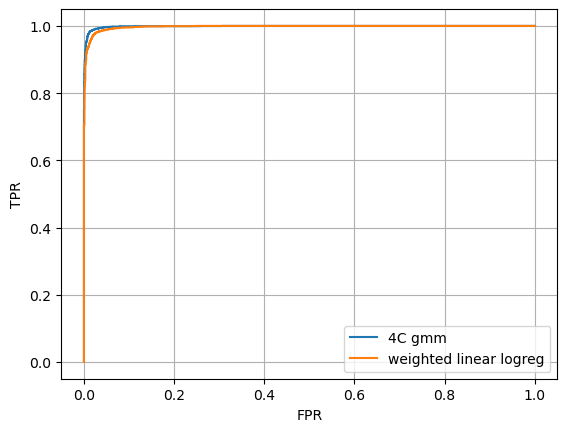

Plotting Bayes Error plot...


KeyboardInterrupt: 

In [9]:
DET = True

z_gmm_llrs = np.load("./results/gmm/llrs_z_norm-gmm-32-full-tied.npy")
z_4c_gmm_llrs = z_gmm_llrs[:,2,:]
llrs_gmm = np.hstack(z_4c_gmm_llrs)

labels = np.hstack(folds_labels).ravel()
print(llrs_gmm.shape, labels.shape)
z_linear_logreg = util.pickle_load("./results/logreg/weighted-z-norm-scores_linear.bin")
logreg_scores = z_linear_logreg[applications[0]][0.5]

if DET:
    plot_labels = ["4C gmm", "weighted linear logreg"]
    print("Plotting ROC plot...")
    plt.plot_ROC([llrs_gmm, logreg_scores], labels, plot_labels)
    print("Plotting Bayes Error plot...")
    plt.bayes_error_plot([llrs_gmm, logreg_scores], labels, plot_labels, [False, False])
    print("Plotting DET plot...")
    plt.plot_DET([llrs_gmm, logreg_scores], labels, plot_labels)

## MVG vs GMM

In [15]:
DET = True

mvg_llrs = util.pickle_load("./results/mvg/z-norm-llrs_tied_full_cov.bin")[(0.5, 1, 1)]
mvg_llrs = np.array(mvg_llrs)
print(llrs_gmm.shape, mvg_llrs.shape)

for application in applications:
    pi, Cfn, Cfp = application
    print(f"application: {application}")
    act_gmm = dcf.compute_act_DCF(llrs_gmm, labels, pi, Cfn, Cfp)
    min_gmm = dcf.compute_min_DCF(llrs_gmm, labels, pi, Cfn, Cfp)
    print(f"\tActual DCF for gmm: {act_gmm}")
    print(f"\tMin DCF for gmm: {min_gmm}")
    act_logreg = dcf.compute_act_DCF(mvg_llrs, labels, pi, Cfn, Cfp)
    min_logreg = dcf.compute_min_DCF(mvg_llrs, labels, pi, Cfn, Cfp)
    print(f"\tActual DCF for MVG: {act_logreg}")
    print(f"\tMin DCF for MVG: {min_logreg}")

if DET:
    plot_labels = ["4C gmm"]
    print("Plotting ROC plot...")
    plt.plot_ROC([llrs_gmm], labels, plot_labels)
    print("Plotting Bayes Error plot...")
    plt.bayes_error_plot([llrs_gmm], labels, plot_labels, [False, False])
    print("Plotting DET plot...")
    plt.plot_DET([llrs_gmm], labels, plot_labels)

(6000,) (6000,)
Plotting ROC plot...


ValueError: operands could not be broadcast together with shapes (6000,) (2,2400) 

### Fusion

(2, 6000) (2, 6000)
(2400,) (2400,) (2400,) (2, 2400)
(0.5, 1, 1) 0.0325 0.03333333333333333
(0.1, 1, 1) 0.09083333333333334 0.10333333333333333
(0.9, 1, 1) 0.07250000000000001 0.07666666666666667


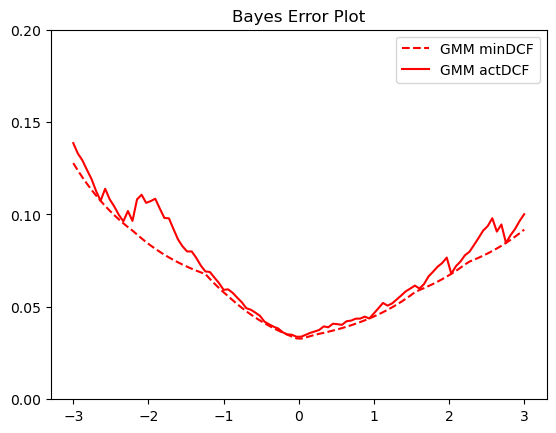

In [22]:
# load tied GMM llrs
z_gmm_llrs = np.load("./results/experimental/gmm/llrs_z_norm-gmm-32-full-tied.npy")
z_4c_gmm_llrs = z_gmm_llrs[:,2,:]
llrs_gmm = np.hstack(z_4c_gmm_llrs)

labels = np.hstack(folds_labels).ravel()

# load RBF scores
RBF_svm_scores = util.pickle_load("./results/experimental/svm/balanced-raw-RBF-svm.bin")[(0.5, 1, 1)][0.5]

# load linear logistic regression results
z_linear_logreg = util.pickle_load("./results/logreg/weighted-z-norm-scores_linear.bin")
logreg_scores = z_linear_logreg[applications[0]][0.5]

# mvg scores
mvg_llrs = util.pickle_load("./results/mvg/z-norm-llrs_tied_full_cov.bin")[(0.5, 1, 1)]
mvg_llrs = np.array(mvg_llrs)

if FUSION:
    scores, labels, limit = lr.score_fusion(llrs_gmm, RBF_svm_scores,  np.hstack(folds_labels), [0.5, 0.5], 0.6)
    
    eval_llrs_gmm = llrs_gmm[limit:]
    eval_RBF_svm_scores = RBF_svm_scores[limit:]
    print(eval_llrs_gmm.shape, eval_RBF_svm_scores.shape, scores.shape, labels.shape)
    for application in applications:
        pi, Cfp, Cfn = application
        minDCF = dcf.compute_min_DCF(eval_llrs_gmm.ravel(), labels, pi, 1, 1)
        actDCF = dcf.compute_act_DCF(eval_llrs_gmm.ravel(), labels, pi, 1, 1)
        print(application, minDCF, actDCF)
    # plt.plot_DET([eval_llrs_gmm, eval_RBF_svm_scores, scores], labels[0], ["GMM", "RBF", "fusion"])
    plt.bayes_error_plot([eval_llrs_gmm], labels, ["GMM"], [False])
